In [1]:
import pandas as pd
import pypsa 
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
        "font.weight": "bold",  # bold fonts
        "font.size":10,
        "lines.linewidth": 2,   # thick lines
        "grid.color": "0.5",    # gray gridlines
        "grid.linewidth": 0.5,  # thin gridlines
        "savefig.dpi": 300,     # higher resolution output.
        "axes.labelsize" : 15
    })

In [2]:
csv_folder_name = "Data_Folder/Eastern_grid_data/Year_data"
network = pypsa.Network()
network.import_from_csv_folder(csv_folder_name)

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network Year_data has buses, generators, lines, loads, storage_units, transformers


In [3]:
solar_inst_cost = 580000
hydro_inst_cost = 2135000#irena
road_per_km_cost = 85088 #article
substation_cost_per_mva = 29364#nea
line_cost_per_km_per_mw = 2100 #article
#40 per kW per year maintainance cost hydro irena 2021

In [4]:
#add capital cost and om cost of generators
#add cost to slack export positive import negative
network.generators['om_cost'] = np.zeros(len(network.generators))
for i in range(len(network.generators)):
    d_sub = network.generators.sub_dist[i]
    d_road = network .generators.road_dist[i]
    typ =network.generators.carrier[i]
    if typ == "Solar":
        network.generators.capital_cost[i] = d_sub * line_cost_per_km_per_mw*network.generators.p_nom[i] + d_road*road_per_km_cost + network.generators.p_nom[i]*solar_inst_cost + substation_cost_per_mva*network.generators.p_nom[i]/0.8
        network.generators.om_cost[i] = network.generators.p_nom[i]*14.1*1000
    if typ == "Hydro":
        network.generators.capital_cost[i] = d_sub * line_cost_per_km_per_mw*network.generators.p_nom[i] + d_road*road_per_km_cost + network.generators.p_nom[i]*hydro_inst_cost + substation_cost_per_mva*network.generators.p_nom[i]/0.8
        network.generators.om_cost[i] = network.generators.p_nom[i]*40*1000

/tmp/ipykernel_3658/3066983289.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3658/3066983289.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3658/3066983289.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3658/3066983289.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [5]:
#updating network with optimal number of generators
def update_network(network,x_opt):
    network_new = network.copy()
    gen_off = np.where(x_opt == 0)
    network_new.generators=network_new.generators.drop(network_new.generators.index[gen_off], axis = 0)
    network_new.generators_t.p_max_pu = network_new.generators_t.p_max_pu.drop(network_new.generators_t.p_max_pu.columns[gen_off],axis= 1)
    return network_new

In [6]:
#from dry analysis
best_bits= np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [7]:
optimal_network = update_network(network,best_bits)

In [8]:
#perform load flow for differernt generation and load condition
def data_norm(Network_data):
    for i in range(len(Network_data.snapshots)):
        snapshot = Network_data.snapshots[i]
        Network_data.generators_t.p_max_pu.iloc[i] = Network_data.generators.p_nom*Network_data.generators_t.p_max_pu.iloc[i] #updating the geneation with max geneartiaon
    return Network_data

In [9]:
optimal_network = data_norm(optimal_network)

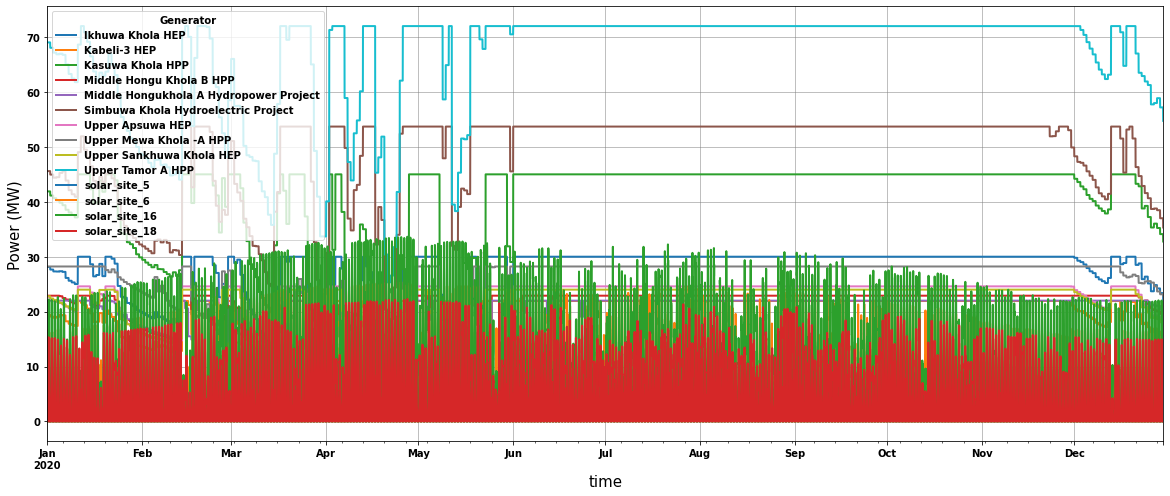

In [10]:
fig,ax = plt.subplots(figsize = (20,8))
optimal_network.generators_t.p_max_pu.plot(ax=ax)
ax.set_xlabel("time")
ax.set_ylabel("Power (MW)")
ax.grid()
plt.savefig("Images/year_generation.jpg",dpi = 300,bbox_inches = 'tight')

In [11]:
cost_data = pd.DataFrame()
cost_data.index = optimal_network.generators_t.p_max_pu.index
cost_data['Total Generation'] = optimal_network.generators_t.p_max_pu.sum(axis = 1)*0.9

<AxesSubplot:xlabel='snapshot'>

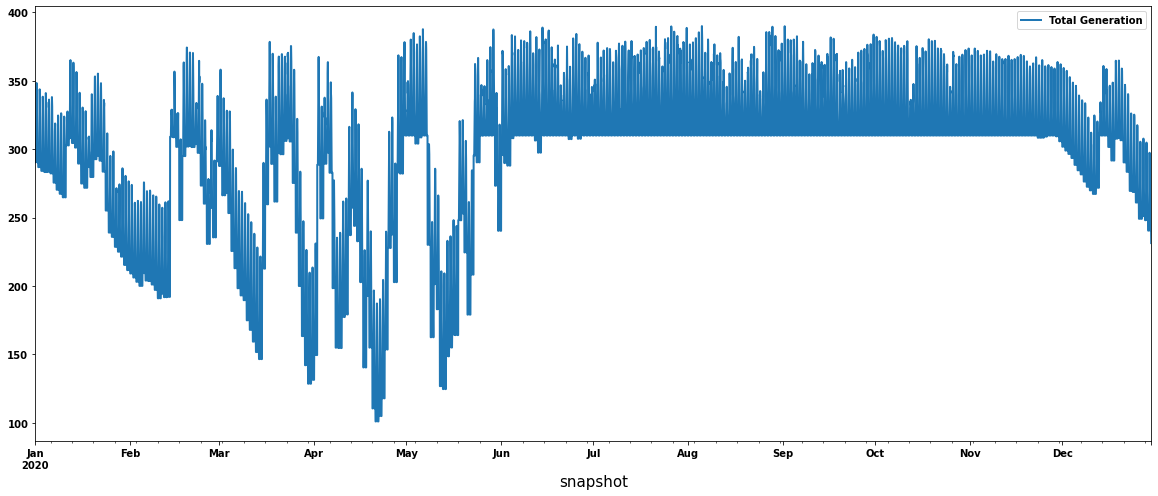

In [12]:
fig,ax = plt.subplots(figsize = (20,8))
cost_data.plot(ax = ax)

In [13]:
dr = 0.1
n = 25
crf = (dr*(1+dr)**n)/(((1+dr)**n)-1)

In [14]:
yearly_energy_kwh = cost_data['Total Generation'].sum()*1000
capital_cost = optimal_network.generators.capital_cost.sum()
yearly_om_cost = optimal_network.generators.om_cost.sum()

In [15]:
Lcoe = (capital_cost*crf + yearly_om_cost)/(yearly_energy_kwh)

In [16]:
Lcoe = pd.DataFrame()
Lcoe['LCOE'] = (optimal_network.generators.capital_cost*crf + optimal_network.generators.om_cost)/(optimal_network.generators_t.p_max_pu.sum()*1000)

In [35]:
xtick = np.array(['GK HPP','IK HEP','Kabeli HPP', "MK HPP","MHA HPP","TK 5 HEP", "UK HPP", "UTA HPP","SS 0","SS 1","SS 2","SS 9","SS 10", "SS 13", "SS 18"])

Text(0.5, 0, 'LCOE')

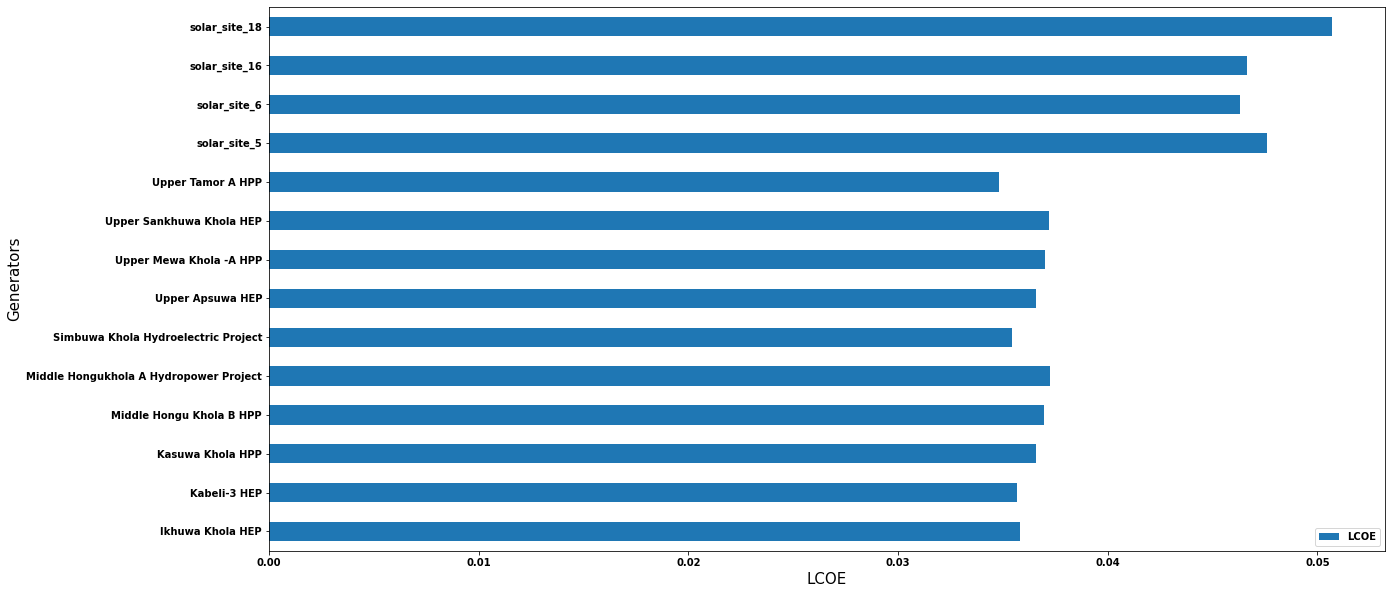

In [17]:
fig,ax = plt.subplots(figsize = (20,10))
Lcoe.plot.barh(ax=ax)
ax.set_ylabel("Generators")
ax.set_xlabel("LCOE")
#plt.savefig("Images/lcoe.jpg",dpi = 300,bbox_inches = 'tight')

NameError: name 'xtick' is not defined

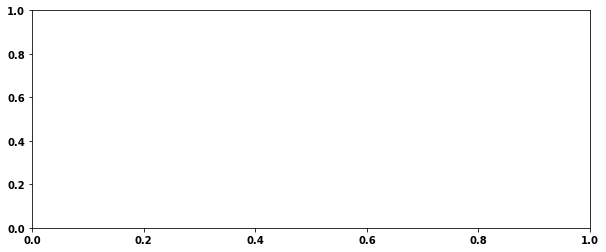

In [18]:
fig,ax = plt.subplots(figsize = (10,4))
ax.bar(xtick,Lcoe.LCOE.values)
ax.set_xlabel("Generators Acronym")
ax.set_ylabel("LCOE")
plt.xticks(rotation=20, ha='right')
plt.savefig("Images/lcoe.jpg",dpi = 300,bbox_inches = 'tight')

In [23]:
import re
genen = pd.read_fwf('gen.txt')
cost = []
for i in range(len(genen)):
    a=float(re.findall('\d*\.?\d+',genen.iloc[i].to_string())[1])
    if a > 100:
        cost.append(a)
cost = np.array(cost)

In [25]:
gen = np.arange(1,41,1)

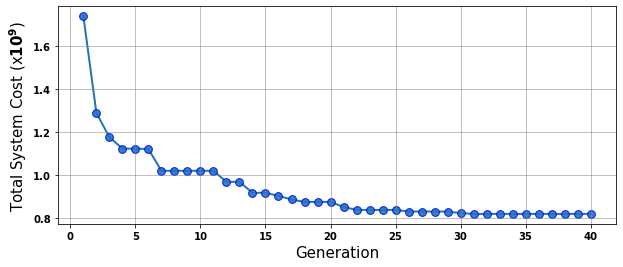

In [26]:
fig,ax = plt.subplots(figsize = (10,4))
ax.scatter(gen,cost/(10**9),s=60, alpha=0.9, edgecolors="b",zorder=1)
ax.plot(gen,cost/(10**9),zorder = 0)
ax.set_ylabel("Total System Cost (x$10^9$)")
ax.set_xlabel("Generation")
ax.grid()
plt.savefig("Images/generation.jpg",dpi = 300,bbox_inches = 'tight')

In [93]:
250/1500

0.16666666666666666

In [94]:
1.8/9.5

0.18947368421052632

In [135]:
mininum = optimal_network.generators_t.p_max_pu.min().values
mininum

array([ 4.60328464,  6.36923496, 16.46024946, 24.80201506, 26.48955502,
       25.42960439, 15.29332851,  6.41642135,  9.39710157, 30.18732857,
        7.54386131,  6.7555428 , 12.28605329, 12.64326147,  5.77195939,
       11.70845975, 19.08407365,  7.27042728, 17.33870311,  7.97580343,
        6.82445174,  7.24796858, 11.14204327, 18.9973282 ,  6.59183446,
       16.20467183,  5.46921623, 19.66220667,  6.55680609, 15.86197609,
        6.81231217, 19.60814144,  6.02377344,  7.54683214,  7.05382146,
        6.41690737,  6.61914286, 14.40930412, 25.32977093, 11.33053839,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [137]:
maximum = optimal_network.generators_t.p_max_pu.max().values
maximum

array([21.        , 23.        , 48.        , 75.        , 83.        ,
       71.5       , 43.        , 21.87      , 30.        , 97.2       ,
       25.        , 21.93      , 37.6       , 45.        , 21.6       ,
       37.7       , 82.        , 24.8       , 50.        , 23.        ,
       22.9       , 22.        , 49.        , 54.        , 21.        ,
       53.7       , 23.5       , 86.        , 22.12      , 40.        ,
       24.6       , 55.        , 24.22      , 24.3       , 22.9       ,
       28.22      , 24.        , 46.81      , 72.        , 32.5       ,
       17.55      , 24.70781539, 18.63      , 46.062     , 25.99933999,
       35.964     , 16.065     , 29.673     , 33.642     , 39.906     ,
       22.302     , 19.602     , 20.547     , 21.114     , 16.713     ,
       15.15846257, 25.43582139, 15.093     , 18.414     , 37.557     ])

In [141]:
1-mininum/maximum

array([0.78079597, 0.72307674, 0.65707814, 0.66930647, 0.68084873,
       0.6443412 , 0.6443412 , 0.70661082, 0.68676328, 0.68943078,
       0.69824555, 0.69194971, 0.67324326, 0.71903863, 0.73277966,
       0.68943078, 0.76726739, 0.70683761, 0.65322594, 0.65322594,
       0.70198901, 0.67054688, 0.77261136, 0.64819763, 0.68610312,
       0.69823702, 0.76726739, 0.77136969, 0.70358019, 0.6034506 ,
       0.72307674, 0.64348834, 0.75128929, 0.68943078, 0.69197286,
       0.77261136, 0.72420238, 0.69217466, 0.64819763, 0.65136805,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [142]:
drop_ratio = np.array([0.78079597, 0.72307674, 0.65707814, 0.66930647, 0.68084873,
       0.6443412 , 0.6443412 , 0.70661082, 0.68676328, 0.68943078,
       0.69824555, 0.69194971, 0.67324326, 0.71903863, 0.73277966,
       0.68943078, 0.76726739, 0.70683761, 0.65322594, 0.65322594,
       0.70198901, 0.67054688, 0.77261136, 0.64819763, 0.68610312,
       0.69823702, 0.76726739, 0.77136969, 0.70358019, 0.6034506 ,
       0.72307674, 0.64348834, 0.75128929, 0.68943078, 0.69197286,
       0.77261136, 0.72420238, 0.69217466, 0.64819763, 0.65136805])

In [143]:
drop_ratio.mean()

0.6969750694999999